In [1]:
# base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

In [2]:
train = pd.read_csv('/home/saule/Light_GBM/Data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
test = pd.read_csv('/home/saule/Light_GBM/Data/test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [4]:
# Смотрим кол-во ненулевых значений
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 10)
pd.DataFrame(data={'NaN_count': train.isna().sum(), 'data_type':train.dtypes})

,NaN_count,data_type
Id,0,int64
MSSubClass,0,int64
MSZoning,0,object
LotFrontage,259,float64
LotArea,0,int64
...,...,...
MoSold,0,int64
YrSold,0,int64
SaleType,0,object
SaleCondition,0,object


In [5]:
# Разделим признаки на числовые и категориальные, тк их обработка будет принциально отличаться
num_features = train.select_dtypes(exclude='object')
cat_features = train.select_dtypes(include='object')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<BarContainer object of 1460 artists>

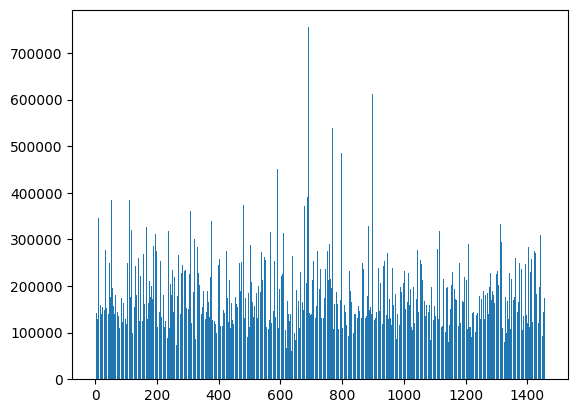

In [6]:
plt.bar(train.index, train['SalePrice'])

In [7]:
train = train[train['SalePrice'] <= 300000]
train['SalePrice'].describe()

count      1345.000000
mean     164246.190335
std       52094.670262
min       34900.000000
25%      128000.000000
50%      156000.000000
75%      196000.000000
max      299800.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

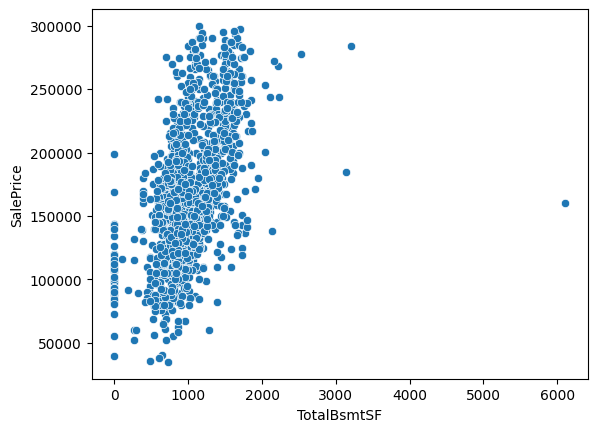

In [8]:
sns.scatterplot(data=train, x='TotalBsmtSF', y='SalePrice')

In [9]:
train = train[train['TotalBsmtSF'] <= 2000]

In [10]:
train['SalePrice'] = np.log(train['SalePrice'])
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216


In [12]:
# Разделим сразу на features и target (таргет у нас test.csv)

X, y = train.drop('SalePrice', axis=1), train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=None, random_state=42)



#### 1.1 Imputation (Заполнение пропусков) 

In [13]:
# Удаляем неинформативные колонки
drop_features = ['Id', "SaleType","YrSold","MiscVal","3SsnPorch","MoSold","FireplaceQu","MiscFeature","PoolArea", \
                 'Alley', 'MasVnrType', 'Utilities', 'RoofMatl', 'BsmtQual', 'BsmtCond', 'Electrical', 'Condition1', \
                 'Condition2', 'Exterior1st', 'Exterior2nd', 'Heating', 'LandSlope', 'Functional', 'ExterQual', 'ExterCond',\
                '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'PoolQC','Fence'] # Alley - тип доступа в переулок (94% пропусков),
# MasVnrType - тип каменной облицовки (59% пропусков)
nan_columns = ['GarageType','GarageFinish','GarageQual','GarageCond', \
               'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"MSZoning","KitchenQual"]

numerical_features = [col for col in X.columns if X[col].dtype != 'object']

my_imputer = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', drop_features),
        #('num_imputer', SimpleImputer(strategy='median'), ['LotFrontage','MasVnrArea']), # LotFrontage - погонные футы улицыБ соединенные с участком (17% пропусков),
        # MasVnrArea - площадь каменного шпона в квадратных футах
        ('nan_fill', SimpleImputer(strategy='constant', fill_value='No'), nan_columns), #Заполняем NaN значением No, чтобы кодировались
        ('cat_imputer', SimpleImputer(strategy='most_frequent'), numerical_features)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' )

#### 1.3 Encoding and Scaling (Кодирование и нормировка данных)

In [14]:
ordinal_encoding_columns = ['KitchenQual','GarageFinish','GarageQual','GarageCond',\
                           'MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', \
                           'BldgType', 'HouseStyle','RoofStyle','Neighborhood', \
                           'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',\
                           'HeatingQC']
standard_scaler_columns = ['TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',\
                          'OpenPorchSF','EnclosedPorch','ScreenPorch',\
                          'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea']
one_hot_encoding_columns = ['GarageType','PavedDrive','SaleCondition', 'CentralAir']


scaler_and_encoder = ColumnTransformer(
    [
        ('one_hot_encoding_columns', OneHotEncoder(sparse_output=False), one_hot_encoding_columns),
        ('scaling_num_columns', StandardScaler(), numerical_features),
        ('ordinal_encoding', OrdinalEncoder(), ordinal_encoding_columns)
   
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

#### 1.4 total Preprocessor

In [16]:
preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('scaler_and_encoder', scaler_and_encoder)
    ]
)

In [17]:
preprocessor 

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_features', 'drop',
                                                  ['Id', 'SaleType', 'YrSold',
                                                   'MiscVal', '3SsnPorch',
                                                   'MoSold', 'FireplaceQu',
                                                   'MiscFeature', 'PoolArea',
                                                   'Alley', 'MasVnrType',
                                                   'Utilities', 'RoofMatl',
                                                   'BsmtQual', 'BsmtCond',
                                                   'Electrical', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Heating',
                                                   'Lan...
                                                   'GarageArea', 'WoodDeckSF',
                                                   'OpenPorchSF', ...]),
                                                 ('ordinal_encoding',
                                                  OrdinalEncoder(),
                                                  ['KitchenQual',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'MSZoning',
                                                   'Street', 'LotShape',
                                                   'LandContour', 'LotConfig',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'Neighborhood',
                                                   'Foundation', 'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2',
                                                   'HeatingQC'])],
                                   verbose_feature_names_out=False))])

In [18]:
ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor())
    ]
)


In [19]:
ml_pipeline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('drop_features',
                                                                   'drop',
                                                                   ['Id',
                                                                    'SaleType',
                                                                    'YrSold',
                                                                    'MiscVal',
                                                                    '3SsnPorch',
                                                                    'MoSold',
                                                                    'FireplaceQu',
                                                                    'MiscFeature',
                                                                    'PoolArea',
                                                                    'Alley',
                                                                    'MasVnrType',
                                                                    'Utilities',
                                                                    'RoofMatl',
                                                                    'BsmtQual',
                                                                    'BsmtCond',
                                                                    'Electrical',
                                                                    'Condition1',
                                                                    'Condition2',
                                                                    'Exterior1...
                                                                    'OpenPorchSF', ...]),
                                                                  ('ordinal_encoding',
                                                                   OrdinalEncoder(),
                                                                   ['KitchenQual',
                                                                    'GarageFinish',
                                                                    'GarageQual',
                                                                    'GarageCond',
                                                                    'MSZoning',
                                                                    'Street',
                                                                    'LotShape',
                                                                    'LandContour',
                                                                    'LotConfig',
                                                                    'BldgType',
                                                                    'HouseStyle',
                                                                    'RoofStyle',
                                                                    'Neighborhood',
                                                                    'Foundation',
                                                                    'BsmtExposure',
                                                                    'BsmtFinType1',
                                                                    'BsmtFinType2',
                                                                    'HeatingQC'])],
                                                    verbose_feature_names_out=False))])),
                ('model', RandomForestRegressor())])

In [20]:
tree = ml_pipeline.fit(X_train, y_train)

In [21]:
predictions = ml_pipeline.predict(X_train)
rmse = mean_squared_error(y_train, predictions, squared=False) # Вычислите RMSE
print("RMSE модели:", rmse)

RMSE модели: 0.04912260082868078


/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
y_pred_valid = ml_pipeline.predict(X_valid)# Вычисляем RMSE
rmse_valid = mean_squared_error(y_valid, y_pred_valid, squared=False)
print("RMSE на валидационной выборке:", rmse_valid)

RMSE на валидационной выборке: 0.1446341292133478


/home/saule/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Permutation importance**

In [69]:
r = permutation_importance(tree, X_valid, y_valid, n_repeats=30, random_state=0)
importance = pd.Series(dict(zip(X.columns, r['importances_mean']))).sort_values(key=lambda x: abs(x), ascending=False)
importance

OverallQual    0.204544
GrLivArea      0.175009
TotalBsmtSF    0.039436
YearBuilt      0.017659
BsmtFinSF1     0.014576
                 ...   
MasVnrType     0.000000
Condition1     0.000000
Condition2     0.000000
Electrical     0.000000
Exterior2nd    0.000000
Length: 80, dtype: float64

In [70]:
preprocessor.fit_transform(test)

,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,CentralAir_N,CentralAir_Y,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,KitchenQual,GarageFinish,GarageQual,GarageCond,MSZoning,Street,LotShape,LandContour,LotConfig,BldgType,HouseStyle,RoofStyle,Neighborhood,Foundation,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.730864,-0.874711,0.613553,0.363929,-0.751101,0.400766,-0.340945,-1.072885,-0.563316,0.063936,0.517537,-0.649392,-0.368484,-0.654561,-0.775254,-0.080483,-1.215588,-0.818068,-0.258160,-1.028720,-0.751040,-1.029543,-0.20391,-0.918335,-0.898055,-0.687893,-0.988189,1.185511,0.366678,-0.701628,-0.360738,-0.088827,1.818960,-0.057227,-0.092244,-0.038281,1.713905,4.0,3.0,4.0,5.0,3.0,1.0,3.0,3.0,4.0,0.0,2.0,1.0,12.0,1.0,3.0,5.0,3.0,4.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.728490,-0.874711,0.661657,0.897861,-0.054877,0.400766,-0.439695,-1.214908,0.047057,1.063714,-0.297689,-0.338322,0.639542,0.433298,-0.775254,-0.080483,-0.323539,-0.818068,-0.258160,-1.028720,1.237648,0.175997,-0.20391,-0.255371,-0.898055,-0.801409,-0.988189,-0.738518,2.347867,-0.178826,-0.360738,-0.088827,-0.301543,-0.057227,19.730438,-0.038281,1.713905,2.0,3.0,4.0,5.0,4.0,1.0,0.0,3.0,0.0,0.0,2.0,3.0,12.0,1.0,3.0,0.0,6.0,4.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.726115,0.061351,0.324927,0.809646,-0.751101,-0.497418,0.844059,0.678742,-0.563316,0.773668,-0.297689,-0.953599,-0.264750,-0.574165,0.891944,-0.080483,0.294508,-0.818068,-0.258160,0.773083,1.237648,0.175997,-0.20391,-0.255371,0.647066,0.674303,0.301406,0.043982,0.930495,-0.207871,-0.360738,-0.088827,-0.301543,-0.057227,-0.092244,-1.140614,1.713905,4.0,0.0,4.0,5.0,4.0,1.0,0.0,3.0,4.0,0.0,4.0,1.0,8.0,2.0,3.0,2.0,6.0,2.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.723741,0.061351,0.517344,0.032064,-0.054877,0.400766,0.876976,0.678742,-0.450284,0.358376,-0.297689,-0.525879,-0.269260,-0.579190,0.837243,-0.080483,0.243004,-0.818068,-0.258160,0.773083,1.237648,0.175997,-0.20391,0.407593,0.647066,0.712142,0.301406,-0.011253,2.089451,-0.178826,-0.360738,-0.088827,-0.301543,-0.057227,-0.092244,-0.038281,1.713905,2.0,0.0,4.0,5.0,4.0,1.0,0.0,3.0,4.0,0.0,4.0,1.0,8.0,2.0,3.0,2.0,6.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.721367,1.465443,-1.166308,-0.971808,1.337571,-0.497418,0.679475,0.394694,-0.563316,-0.386513,-0.297689,1.059203,0.529042,0.310192,-0.775254,-0.080483,-0.424487,-0.818068,-0.258160,0.773083,-0.751040,-1.029543,-0.20391,-0.918335,-0.898055,0.485109,0.301406,0.154452,-0.729632,0.489198,-0.360738,-0.088827,2.243060,-0.057227,-0.092244,-1.875504,1.713905,2.0,2.0,4.0,5.0,4.0,1.0,0.0,1.0,4.0,4.0,2.0,1.0,22.0,2.0,3.0,0.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.721367,2.401505,-2.224604,-1.591330,-1.447325,1.298950,-0.044694,-0.646813,-0.563316,-0.964407,-0.297689,-0.018104,-1.126195,-1.533893,0.523306,-0.080483,-0.811797,-0.818068,-0.258160,-1.028720,1.237648,0

In [43]:
answer = ml_pipeline.predict(test)

In [44]:
ans = test[['Id']].copy()
ans.insert(1, "SalePrice", answer, True)

In [45]:
ans['SalePrice'] = ans['SalePrice'].map(lambda a: np.exp(a))

In [46]:
ans.to_csv('submission.csv', index=False)

In [48]:
import joblib

In [49]:
joblib.dump(ml_pipeline, 'ml_pipeline_house.pkl')

['ml_pipeline_house.pkl']